In [1]:
# import tools
import pandas as pd
%matplotlib inline
import qiime2
from qiime2 import Artifact
from tempfile import mkdtemp
from qiime2.plugins import demux, deblur, quality_filter, \
                           metadata, feature_table, alignment, \
                           phylogeny, diversity, emperor, feature_classifier, \
                           taxa, composition
from qiime2.plugins import fragment_insertion
from qiime2.plugins.fragment_insertion.methods import filter_features
from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.visualizers import summarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pylab
from scipy.optimize import curve_fit

Ran this comman in a barnacle interactive environment qsub -I -V
source activate qiime2-2019.7
qiime feature-classifier classify-sklearn   --i-classifier /databases/qiime2_qza/gg-13-8-99-nb-classifier.qza   --i-reads 94617_reference-hit.seqs.qza   --p-n-jobs 8   --o-classification 94617_reference-hit.taxonomy_gg.qza

## Import Data

In [2]:
# 
table = Artifact.load('/Volumes/GoogleDrive/My Drive/PhD/Isolation_Dorm/Dorm_analysis/data/137124-feature-table.qza')
tx = Artifact.load('/Volumes/GoogleDrive/My Drive/PhD/Isolation_Dorm/Dorm_analysis/data/137124-reference-hit.taxonomy_gg.qza').view(pd.DataFrame)

## Quantify reads aligning to positve control

In [3]:
# see what it looks like at ASV level
df_raw = table.view(pd.DataFrame)
df_raw_kath = df_raw[df_raw.index.str.contains('KATHARO')]
# ensure table values are numeric
df_raw_kath = df_raw_kath.astype(float)
# quick visual check that top 7 taxa make up most of the reads in highest input sample (well A7)
max_input = df_raw_kath[df_raw_kath.index.str.contains("12A|11A|10H|9A|8A")]
df_raw_kathT = max_input.T
top10 = df_raw_kathT.sort_values(df_raw_kathT.columns[0], ascending = False).head(10)
# add in taxonomy
top10tx = pd.merge(top10, tx, left_index=True, right_index=True)
top10tx.reset_index(inplace=True)
top10tx.set_index('Taxon').head(5)


,index,13957.KATHARO1.12A,13957.KATHARO3.10H,13957.KATHARO4.9A,13957.KATHARO2.11A,13957.KATHARO5.8A,Confidence
Taxon,,,,,,,
k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Bacillus; s__,TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCT...,32676.0,25108.0,36699.0,35715.0,38083.0,0.8692011958399442
k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Paracoccus; s__,TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCA...,4160.0,4370.0,8410.0,7565.0,8182.0,0.7379380883071627
k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Bacillus,TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCT...,1768.0,919.0,1439.0,1401.0,1305.0,0.8892437937043013
k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Bacillus; s__,TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCT...,363.0,361.0,361.0,512.0,689.0,0.9445516187667186
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Oxalobacteraceae; g__Ralstonia; s__,TACGTAGGGTCCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTG...,8.0,21.0,0.0,4.0,0.0,0.999820555057887


In [4]:
# make a list of the taxa expected in the Katharo community (also the  most abundant in the highest input samples)
bacteria4 = top10tx.head(4)['index']

In [5]:
# Calculate the total number of reads per sample
df_raw_kath['deblur_reads'] = df_raw_kath.sum(axis=1)
# calculate the number of reads aligning to the mock community input genera
df_raw_kath['kath_reads'] = df_raw_kath[bacteria4].sum(axis=1)
# calculate the percent correctly assigned
df_raw_kath['correct_assign'] = df_raw_kath['kath_reads'] / df_raw_kath['deblur_reads']

In [6]:
# subset out KatharoSeq columns and add in logarithim of reads for plotting
katharo = df_raw_kath[['correct_assign','deblur_reads','kath_reads']]
katharo['log_deblur_reads'] = np.log10(katharo['deblur_reads'])

/var/folders/4y/4cpz9m8d70l80zdcqlxq6p4c0000gp/T/ipykernel_79162/158095675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  katharo['log_deblur_reads'] = np.log10(katharo['deblur_reads'])


## Fit an allosteric sigmoid curve for extrapolating min read count

[8.58003327e+00 1.00587473e+04]


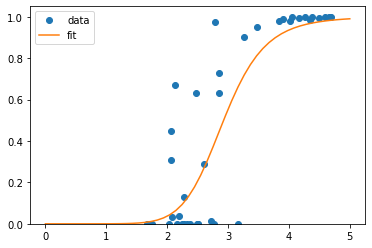

In [19]:
# define the allosteric sigmoid equation
def allosteric_sigmoid(x, h, k_prime):
    y = x ** h / (k_prime + x ** h)
    return y
 
# fit the curve to your data
popt, pcov = curve_fit(allosteric_sigmoid, katharo['log_deblur_reads'], katharo['correct_assign'], method='dogbox')
print(popt)
# plot fit curve
x = np.linspace(0, 5, 50)
y = allosteric_sigmoid(x, *popt)

# plot the fit
pylab.plot(katharo['log_deblur_reads'], katharo['correct_assign'], 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0, 1.05)
pylab.legend(loc='best')
pylab.savefig('./figs/sup2a.svg')
pylab.show()




In [8]:
plt.savefig('./figs/sup2a.svg', format='svg')

<Figure size 432x288 with 0 Axes>

In [19]:
# Determine the number of reads at which 80% of reads are expected to match input

# assign variables and solve for X (number of reads to pass filter)
h = popt[0]  # first value printed above graph
k = popt[1]   # second value printed above graph
y = 0.8 ## what you want to solve for

min_log_reads = np.power((k/((1/y)-1)),(1/h))
min_freq_80 = np.power(10, min_log_reads).astype(int)
min_freq_80

2759

## Remove samples with less than Katharoseq read limit

In [20]:
# filter out samples with read counts below what is estimated to achieve 80% accuracy  
KS_table_80 = feature_table.methods.filter_samples(table = table,
                             min_frequency = min_freq_80)
df_80 = KS_table_80.filtered_table.view(pd.DataFrame)

In [21]:
# import collapsed table as pandas dataframe
print("full dataset", len(df_raw), "\n",
      "80%", len(df_80), len(df_80)/len(df_raw),"%", "\n")

full dataset 472 
 80% 305 0.6461864406779662 % 



The hospital paper only held onto 55% of samples, so this looks good.

## Export Data

In [22]:
KS_table_80.filtered_table.save('/Volumes/GoogleDrive/My Drive/PhD/Isolation_Dorm/Dorm_analysis/data/137124-feature-table-KathSeqFil.qza')

'/Volumes/GoogleDrive/My Drive/PhD/Isolation_Dorm/Dorm_analysis/data/137124-feature-table-KathSeqFil.qza'

In [25]:
##May need to be redone depending on which are the mock communities. But still, a higher 
##microbial load than the hospital paper, but greater retention of samples!
katharo.sort_index() 

,correct_assign,deblur_reads,kath_reads,log_deblur_reads
13957.KATHARO1.12A,0.998872,39011.0,38967.0,4.591187
13957.KATHARO1.12B,0.986126,22560.0,22247.0,4.353339
13957.KATHARO1.12C,0.978341,10342.0,10118.0,4.014605
13957.KATHARO1.12D,0.630404,717.0,452.0,2.855519
13957.KATHARO1.12E,0.131579,190.0,25.0,2.278754
13957.KATHARO1.12F,0.000000,177.0,0.0,2.247973
13957.KATHARO1.12G,0.000000,589.0,0.0,2.770115
13957.KATHARO1.12H,0.000000,1479.0,0.0,3.169968
13957.KATHARO2.11A,0.996692,45343.0,45193.0,4.656510
13957.KATHARO2.11B,0.997089,11335.0,11302.0,4.054422
